<a href="https://colab.research.google.com/github/SheshamJoseph/Deep-Learning-with-Tensorflow-ZTM/blob/main/05_tranfer_learning_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Tensorflow Part 2: Fine Tuning

In this section, we are going to:
* Introduce **fine-tuning transfer learning** with Tensorflow
* Introduce the **KerasFunctional API** to build models
* Using small dataset to experiment faster(eg. 10% of training data)
* **Data Augumentation**
* Running a series of experiments on our Food Vision data
* Introduce the **Model Checkpoint** callback

In [ ]:
# check if we're using gpu
! nvidia-smi

Mon Jan 22 17:24:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Creating Helper Functions

This script was gotten from the Deep Learning with TensorFlow Course repo at this [link](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py)

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-01-22 17:29:48--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-01-22 17:29:48 (102 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

##  Let's get the data

This time we're going to see how to use the pre-trained models in `tf.keras.applications` and apply them to our problem.

In [ ]:
# get 10% of training data from the food_10_classes dataset
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2024-01-22 17:44:48--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.192.207, 209.85.145.207, 209.85.146.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.192.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   246MB/s    in 0.7s    

2024-01-22 17:44:49 (246 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# check out the number of images and sub-directories
walk_through_dir("10_food_classes_10_percent/")

There are 2 directories and 0 images in '10_food_classes_10_percent/'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percen

In [ ]:
# Create training and test directory path
train_dir = "10_food_classes_10_percent/train/"
test_dir ="10_food_classes_10_percent/test/"


In [ ]:
import tensorflow as tf
import keras
from keras.utils import image_dataset_from_directory

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
# creating the training and testing datasets
train_dataset_10_percent = image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    label_mode='categorical',
    batch_size=BATCH_SIZE
)

test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    label_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_dataset_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
class_names = train_dataset_10_percent.class_names

In [ ]:
class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# see  a sample batch of data
for images, labels in train_dataset_10_percent.take(1):
    print(images, labels)

tf.Tensor(
[[[[158.81633    53.158165   85.801025 ]
   [179.5204     77.66327   107.331635 ]
   [189.52551    90.938774  119.44388  ]
   ...
   [ 47.857185   31.857187   15.857186 ]
   [ 51.571415   34.571415   18.571415 ]
   [ 48.928535   31.928537   15.928536 ]]

  [[158.02551    64.92857   101.811226 ]
   [178.42348    86.19898   122.9898   ]
   [182.58673    91.33163   125.67346  ]
   ...
   [ 49.84186    33.056126   17.056124 ]
   [ 49.209194   32.209194   16.209196 ]
   [ 50.         33.         17.       ]]

  [[159.35204    74.581635  115.505104 ]
   [175.86736    89.0102    130.93877  ]
   [164.16327    73.26021   111.688774 ]
   ...
   [ 52.551006   35.122437   18.999977 ]
   [ 53.913277   34.484703   19.056133 ]
   [ 54.642857   35.214287   19.785713 ]]

  ...

  [[163.71945    55.13798    87.70939  ]
   [174.58153    61.913445   87.81134  ]
   [184.14268    64.66855    85.6685   ]
   ...
   [ 68.73983    63.336708   62.525562 ]
   [ 67.         61.214264   60.571472 ]
   [ 

## The TensorFlow Functional API
Building a transfer learning model using the Functional API

In [ ]:
from posixpath import dirname
# 1. Create a model
base_model = keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so underlying pre-trained layers aren't updated)
base_model.trainable=False

# 3. Create input layer
inputs = tf.keras.layers.Input(shape=IMG_SIZE+(3,), name='input_layer')

#4. Rescaling the input
# x = tf.keras.layers.Rescaling(1./255)(inputs)

# EfficientNetB0 doesn't require rescaling
# 5. Pass the inputs to the base model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pools the outputs of the base model(aggregates all the most important information, reduces computation)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling_layer')(x)
print(f"Shape after passing inputs GlobalAveragePooling2D layer: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# 8. Combine the inputs and outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# compile the model
model_0.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# fit the model
hist_0 = model_0.fit(
    train_dataset_10_percent,
    epochs=5,
    steps_per_epoch=len(train_dataset_10_percent),
    validation_data=test_dataset,
    validation_steps=int(0.25 * len(test_dataset)),
    callbacks=[create_tensorboard_callback(
        dir_name='transfer_learning',
        experiment_name='10_percent_feature_extraction'
    )]
)

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after passing inputs GlobalAveragePooling2D layer: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20240122-184726
Epoch 1/5
24/24 [==============================] - 23s 328ms/step - loss: 1.8546 - accuracy: 0.4333 - val_loss: 1.2923 - val_accuracy: 0.6974
Epoch 2/5
24/24 [==============================] - 4s 135ms/step - loss: 1.0815 - accuracy: 0.7707 - val_loss: 0.8737 - val_accuracy: 0.8174
Epoch 3/5
24/24 [==============================] - 5s 176ms/step - loss: 0.7882 - accuracy: 0.8333 - val_loss: 0.6790 - val_accuracy: 0.8569
Epoch 4/5
24/24 [==============================] - 5s 181ms/step - loss: 0.6432 - accuracy: 0.8667 - val_loss: 0.6174 - val_accuracy: 0.8487
Epoch 5/5
24/24 [==============================] - 5s 176ms/step - loss: 0.5394 - accuracy: 0.8800 - val_loss: 0.5397 - val_accuracy: 0.8684


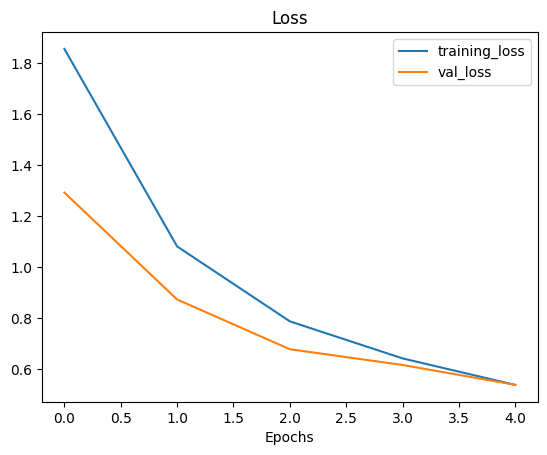

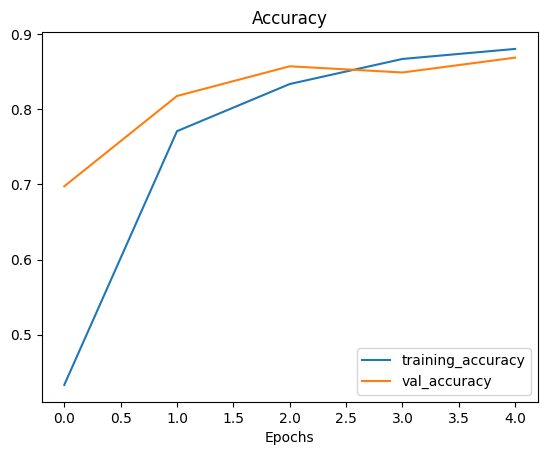

In [ ]:
plot_loss_curves(hist_0)

In [ ]:
# Evaluate on full test dataset
model_0.evaluate(test_dataset)

79/79 [==============================] - 8s 92ms/step - loss: 0.5527 - accuracy: 0.8660


[0.5526783466339111, 0.8659999966621399]

In [ ]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_3
1 rescaling_2
2 normalization_1
3 rescaling_3
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [ ]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, None, None, 3)        0         ['input_3[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, None, None, 3)        7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, None, None, 3)        0         ['normalization_1

In [ ]:
model_0.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_avg_pooling_layer (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
_________________________________________________________________
